# Overview of object detection #
Reference: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/

In [1]:
import os
import sys
import json
import glob 
from xml.etree import ElementTree as ET
from collections import namedtuple
from typing import NamedTuple, List, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
import pandas as pd

NINPY_DIR = os.path.expanduser("~/github/ninpy/")
sys.path.append(NINPY_DIR)

In [2]:
LABEL_MAP = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19
    }

# def parse_xml(xml_dir: List[str]) -> List[NamedTuple]:
#     """Parse a xml file and collects all necessary information."""
#     tree = ET.parse(xml_dir)
#     root = tree.getroot() 
#     Object = namedtuple("Object", "label xmin xmax ymin ymax difficult")
    
#     objs = []
#     for obj in root.iter("object"):
#         name = obj.find("name").text
#         label = LABEL_MAP[name]
#         bndbox = obj.find("bndbox")
#         # The bounding box starts with 0.
#         xmin = int(bndbox.find("xmin").text) - 1
#         xmax = int(bndbox.find("xmax").text) - 1
#         ymin = int(bndbox.find("ymin").text) - 1
#         ymax = int(bndbox.find("ymax").text) - 1
#         difficult = int(obj.find("difficult").text)
#         objs.append(Object(label, xmin, xmax, ymin, ymax, difficult))
#     return objs

def parse_xml(xml_dir: List[str]) -> List[List[int]]: #List[NamedTuple]:
    """Parse a xml file and collects all necessary information."""
    tree = ET.parse(xml_dir)
    root = tree.getroot() 
    #Object = namedtuple("Object", "label xmin xmax ymin ymax difficult")
    objs = []
    for obj in root.iter("object"):
        name = obj.find("name").text
        label = LABEL_MAP[name]
        bndbox = obj.find("bndbox")
        # The bounding box starts with 0.
        xmin = int(bndbox.find("xmin").text) - 1
        xmax = int(bndbox.find("xmax").text) - 1
        ymin = int(bndbox.find("ymin").text) - 1
        ymax = int(bndbox.find("ymax").text) - 1
        difficult = int(obj.find("difficult").text)
        objs.append([xmin, xmax, ymin, ymax, difficult, label])
        #objs.append(Object(label, xmin, xmax, ymin, ymax, difficult))
    return objs

annotation_dir = "~/datasets/voc/VOCdevkit/VOC2007/Annotations/"
annotation_dir = os.path.expanduser(annotation_dir)
xml_dirs = glob.glob(os.path.join(annotation_dir, "*.xml"))
annotations = [parse_xml(x) for x in xml_dirs]

In [3]:
def get_train_test_annotations(root: str) -> Tuple[List[str]]:
    """Expect:
    `root`___VOCdevkit___VOC2007
                     |___VOC2012
    """
    assert isinstance(root, str)
    root = os.path.expanduser(root)
    voc07 = os.path.join(root, "VOCdevkit", "VOC2007")
    voc12 = os.path.join(root, "VOCdevkit", "VOC2012")
    train_imgs, test_imgs, train_labels, test_labels = [], [], [], []

    for voc in [voc07, voc12]:
        base_txt = os.path.join(voc, "ImageSets", "Main")
        base_annot = os.path.join(voc, "Annotations")
        base_img = os.path.join(voc, "JPEGImages")

        trainval = os.path.join(base_txt, "trainval.txt")
        trainval_names = np.loadtxt(trainval, str)
        train_label = [
            parse_xml(os.path.join(base_annot, i + ".xml")) for i in trainval_names]
        train_img = [
            os.path.join(base_img, i + ".jpg") for i in trainval_names]
    
        if voc.find("VOC2007") > -1:
            # VOC2012 does not contain test.txt.
            # Find test.txt only for VOC2007.
            test = os.path.join(base_txt, "test.txt")
            test_names = np.loadtxt(test, str)
            test_label = [
                parse_xml(os.path.join(base_annot, i + ".xml")) for i in test_names]
            test_img = [
                os.path.join(base_img, i + ".jpg") for i in test_names]
            test_imgs += test_img
            test_labels += test_label

        train_imgs += train_img
        train_labels += train_label
    assert len(train_imgs) == len(train_labels)
    assert len(test_imgs) == len(test_labels)
    return train_imgs, train_labels, test_imgs, test_labels

train_imgs, train_labels, test_imgs, test_labels = get_train_test_annotations(
    "~/datasets/voc/")

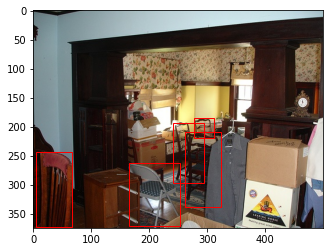

In [4]:
from ninpy.datasets.utils import cv2_loader
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def xyminmax2xyhw(xy_min_max: List[int]) -> NamedTuple:
    """Convert xy-min xy-max (PASCAL) format to xyhw (COCO) namedtuple.
    xyhw can be used with OpenCV Rectangular object.
    Args:
        xy_min_max (list): x_min, x_max y_min, y_max, difficult, label
    """
    Object = namedtuple("Object", "x y h w")
    xmin = xy_min_max[0]; xmax = xy_min_max[1]
    ymin = xy_min_max[2]; ymax = xy_min_max[3]
    h = xmax - xmin
    w = ymax - ymin
    return Object(xmin, ymin, h, w)

img, label = train_imgs[0], train_labels[0]
img = cv2_loader(img)
plt.imshow(img)
for l in label:
    l = xyminmax2xyhw(l)
    x, y, h, w = l.x, l.y, l.h, l.w
    rect = Rectangle((x, y), h, w, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

In [5]:
from ninpy.datasets import BurstDataset
from ninpy.datasets.utils import cv2_load_images, pil_loader
from typing import Callable, Optional, NamedTuple, List, Union
import torch
from torchvision import transforms


class PascalDetection(BurstDataset):
    """Pascal VOC datasets: Train: VOC2007 + VOC 2012. Test: VOC2007."""
    def __init__(
        self,
        loader: Callable,
        target_loader: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
        ) -> None:
        super().__init__(loader, target_loader, transform, target_transform)

    def collate_fn(self, batch: List[Union[torch.Tensor, List[int]]]):
        """Objects in a image. Put this into Dataloader(collate_fn=collate_fn).
        Ex: batch: [[images, objects], ...num_batch]
        """
        targets = []
        # Expected a fixed size of images.
        # However, requires list for not fixed-size variables.
        images = torch.zeros(
            len(batch), *batch[0][0].shape,
            device=batch[0][0].device)
        for idx, b in enumerate(batch):
            image, obj = b
            images[idx, :, :, :] = image
            targets.append(obj)
        return images, targets


transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor()
])
train_dataset = PascalDetection(pil_loader, transform=transform)
train_dataset.set_data_label_dirs(train_imgs, train_labels)
train_img, train_label = next(iter(train_dataset))
# train_dataset.load_images(cv2_load_images)
# train_dataset.load_labels()

In [6]:
train_label

[[262, 323, 210, 338, 0, 8],
 [164, 252, 263, 371, 0, 8],
 [4, 66, 243, 373, 1, 8],
 [240, 294, 193, 298, 0, 8],
 [276, 311, 185, 219, 1, 8]]

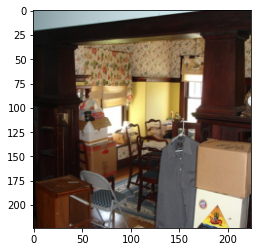

In [7]:
from torch.utils.data import DataLoader
from ninpy.torch2 import torch2np
import matplotlib.pyplot as plt

train_loader = DataLoader(
    train_dataset, collate_fn=train_dataset.collate_fn,
     batch_size=3, num_workers=0)
train_images, train_objs = next(iter(train_loader))

train_image = torch2np(train_images[0])
plt.imshow(train_image)
plt.show()

In [8]:
from typing import List

def xyminmax2cxcyhw(xyminmax: List[int]) -> List[int]:
    """Convert xyminmax and cxcyhw format."""
    
    return

def create_priors():
    """Get prior boxes with cxcyhw format.
    Priors are used to allow a discrete optimization.
    Small priors in early layers which contain more feature maps.
    Large priors in early layers which contain more feature maps.
    """
    return



In [9]:
class SSD(nn.Module):
    def __init__(self, backend: nn.Module) -> None:
        super().__init__()
        # Expect several outputs from a backend.
        self.backend = backend

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.backend(input)
        assert len(output) == 4, ""

        return

In [11]:
def jaccard_overlap():
    """Jaccard overlap """

    return

# Modify bounding box after resize or crop images.
# Prior finding in each dataset optimization.

class SSDLoss(nn.Module):
    """SSDLoss = regression + recognition.
    Args:
        threshold (float): pred_cls > threshold ? pred_cls: 0.
        alpha (float): a fraction between classification loss and locatization loss.
    """
    def __init__(self, threshold: float, alpha: float = 1.0) -> None:
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.threshold = threshold
        self.alpha = alpha

    def forward(
        self,
        pred_loc: torch.Tensor,
        pred_cls: torch.Tensor,
        true_boxes: List[List[int]],
        true_labels: torch.Tensor,
        ) -> torch.Tensor:
        """Args:
            pred_loc (torch.Tensor): [N, 8732, 4]
            pred_cls (torch.Tensor): [N, 8732, N_CLASSES]
            true_boxes (list): [N, N_OBJECTS, 4 + 2]
            true_labels (torch.Tensor): [N, N_OBJECTS]
        """
        # Find max overlap between a true box and  with jaccard.
        batch_size = pred_loc.shape[0]
        for i in range(batch_size):
            true_box = true_boxes[i]
            # Having a box, find best matching box.
            true_box = true_boxes
            




        

        # Non max suppression

        # Confident recognition > threshold


        # convert cxcy2 ?

        # l1 loss

        # Hard negative mining.

        # Sum lossse
        all_losses = self.alpha
        return all_losses



In [12]:
# Precision = TP/(TP + FP) and Recall = TP/(TP + FN).
# IoU = Overlap/Union.
# IoU >= threshold 0.5, 0.75, 0.95
# AP = Smooth average area of precision and recall.
# There are points of data to sum in AP.
# In VOC, need to use 11, COCO using 101 points to find AP?




def get_map(preds, labels):
    """Find mean Average Precision"""

    return

def find_intersect():
    """Find intersection between two bounding box in xyminmax format."""



    return


def find_iou(b0, b1):
    """Using torch to find IoU.
    '"""
    xmin0, xmax0, ymin0, ymax0 = b0
    xmin1, xmax1, ymin1, ymax1 = b1


    return

